In [1]:
import os
from datetime import datetime
import numpy as np
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords, interplevel, get_cartopy,  xy_to_ll, ll_to_xy, smooth2d
import wrf
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import glob
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
from matplotlib.cm import get_cmap
from statistics import multimode, mode
from scipy.ndimage import label, find_objects
import scipy.stats as stats
import pickle

In [2]:
# Initialize an empty list to store the filtered ivt arrays
thompson_ivt_list = []
thompsonaa_ivt_list = []
wsm6_ivt_list = []
wdm6_ivt_list = []
ntu_ivt_list = []
ishmael_ivt_list = []
p3_ivt_list = []
p3_3mom_ivt_list = []
p3_2xcloud_ivt_list = []
p3_2nd_ivt_list = []

In [3]:
ensemble_3_sigma = 775
ensemble_2_sigma = 648

In [4]:
# Get a list of all .npy files in the directory
file_paths = glob.glob('/scratch/sawyer/wwrf/2017-01-09/ensemble_data/ivt/*.npy')

# Loop through each file and load, filter, and append the data
for file in file_paths:
    
    ivt_arrays = np.load(file, allow_pickle=True)
    ivt_nan = np.where(ivt_arrays < 250, np.nan,ivt_arrays)
    flat_ivt = ivt_nan[~np.isnan(ivt_nan)]
    if 'thompson' in file:
        thompson_ivt_list.append(flat_ivt)
    elif 'thopmson_aa' in file:
        thompsonaa_ivt_list.append(flat_ivt)
    elif 'wsm6' in file:
        wsm6_ivt_list.append(flat_ivt)
    elif 'wdm6' in file:
        wdm6_ivt_list.append(flat_ivt)
    elif 'ntu' in file:
        ntu_ivt_list.append(flat_ivt)
    elif 'ishamel' in file:
        ishmael_ivt_list.append(flat_ivt)
    elif 'p3_2xcloud' in file:
        p3_2xcloud_ivt_list.append(flat_ivt)
    elif 'p3_2nd' in file:
        p3_2nd_ivt_list.append(flat_ivt)
    elif 'p3mom' in file:
        p3_3mom_ivt_list.append(flat_ivt)
    else:
        p3_ivt_list.append(flat_ivt)
    

In [5]:
# 2. Initialize an empty DataFrame
df = pd.DataFrame(columns=["Ensemble member", "IVT 2-sigma", "IVT 3-sigma",
                           "Mean IVT","Standard Deviation", "Total IVT", "Grid Cells above 2 sigma", "Grid Cells above 3 sigma"])

In [6]:
# List of all the lists
ivt_lists = [
    thompson_ivt_list,
    thompsonaa_ivt_list,
    wsm6_ivt_list,
    wdm6_ivt_list,
    ntu_ivt_list,
    ishmael_ivt_list,
    p3_ivt_list,
    p3_3mom_ivt_list,
    p3_2xcloud_ivt_list,
    p3_2nd_ivt_list
]

# List of names for each list for clearer printing
list_names = [
    "thompson",
    "thompson_aa",
    "wsm6",
    "wdm6",
    "ntu",
    "ishmael",
    "p3",
    "p3_3mom",
    "p3 2xcloud",
    "p3 2nd"
]

# Loop through each list and print its length
for ivt_list, list_name in zip(ivt_lists, list_names):
    concatenated_ivt = np.concatenate(ivt_list)
    print(f"Shape of concatenated {list_name}: {concatenated_ivt.shape}")
    print(f"Length of {list_name}: {len(ivt_list)}")
    sigma = np.std(concatenated_ivt)
    mu = np.mean(concatenated_ivt)
    print('sigma: ', sigma)
    print('mu: ', mu)
    two_sigma = (sigma*2) + mu
    three_sigma = (sigma*3) + mu
    print('two_sigma: ', two_sigma)
    print('three_sigma: ', three_sigma)
    total_ivt = np.sum(concatenated_ivt)
                                
    mask_3_sigma = concatenated_ivt >= ensemble_3_sigma
    mask_2_sigma = concatenated_ivt >= ensemble_2_sigma
    mask = np.ma.array(concatenated_ivt, mask=~mask_3_sigma)
    mask_2 = np.ma.array(concatenated_ivt, mask=~mask_2_sigma)
    cells_above_three_sigma = mask.count()
    cells_above_two_sigma = mask_2.count()
    print("grid_cells_above_ 3 sigma: ",cells_above_three_sigma)
    print("grid_cells_above_ 2 sigma: ",cells_above_two_sigma)
    

    df = df.append({
    "Ensemble member": list_name,
    "IVT 2-sigma": round(two_sigma),
    "IVT 3-sigma": round(three_sigma),
    "Mean IVT": round(mu),
    "Standard Deviation": round(sigma),
    "Total IVT": round(total_ivt),
    "Grid Cells above 3 sigma": cells_above_three_sigma,
    "Grid Cells above 2 sigma": cells_above_two_sigma,
}, ignore_index=True)


Shape of concatenated thompson: (2297191,)
Length of thompson: 55
sigma:  126.31624
mu:  395.68585
two_sigma:  648.3183288574219
three_sigma:  774.6345672607422
grid_cells_above_ 3 sigma:  27217
grid_cells_above_ 2 sigma:  123472
Shape of concatenated thompson_aa: (2240686,)
Length of thompson_aa: 55
sigma:  124.60087
mu:  394.13715
two_sigma:  643.3388824462891
three_sigma:  767.9397506713867
grid_cells_above_ 3 sigma:  27758
grid_cells_above_ 2 sigma:  115307
Shape of concatenated wsm6: (2156003,)
Length of wsm6: 56
sigma:  125.50675
mu:  394.3182
two_sigma:  645.3317108154297
three_sigma:  770.8384628295898
grid_cells_above_ 3 sigma:  29557
grid_cells_above_ 2 sigma:  116730
Shape of concatenated wdm6: (2406008,)
Length of wdm6: 56
sigma:  130.59964
mu:  398.76523
two_sigma:  659.9645080566406
three_sigma:  790.5641479492188
grid_cells_above_ 3 sigma:  44245
grid_cells_above_ 2 sigma:  138811
Shape of concatenated ntu: (2415222,)
Length of ntu: 56
sigma:  130.85796
mu:  397.08865
tw

/tmp/ipykernel_44398/3725315275.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_44398/3725315275.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_44398/3725315275.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_44398/3725315275.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_44398/3725315275.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_44398/3725315275.py:54: Future

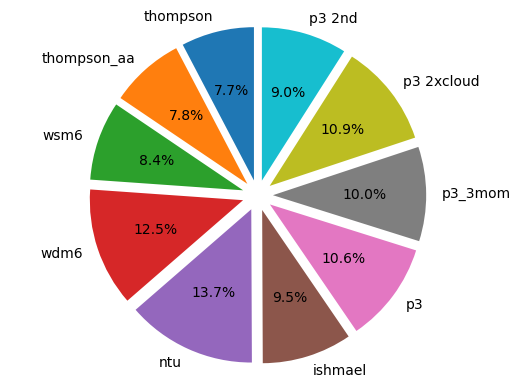

In [7]:
# Create the pie chart
fig, ax = plt.subplots()
explode = (0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
ax.pie(df["Grid Cells above 3 sigma"], labels=df["Ensemble member"], autopct='%1.1f%%', startangle=90,explode=explode)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.title('Percentage of Grid Cells above 3 sigma for each Ensemble Member')
plt.show()

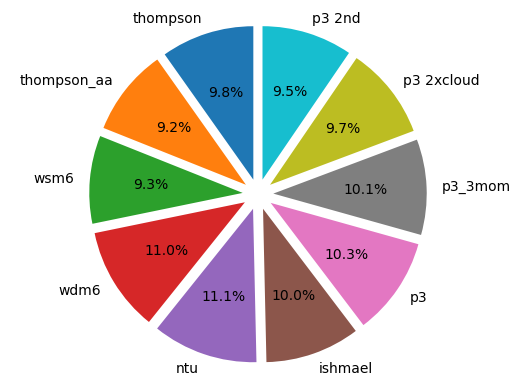

In [8]:
# Create the pie chart
fig, ax = plt.subplots()
ax.pie(df["Grid Cells above 2 sigma"], labels=df["Ensemble member"], autopct='%1.1f%%', startangle=90, explode=explode)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.title('Percentage of Grid Cells above 2 sigma for Each Ensemble Member')
plt.show()

In [9]:
sigma = np.std(ensemble_ivt)
mu = np.mean(ensemble_ivt)

print('sigma: ', sigma)
print('mu: ', mu)
two_sigma = (sigma*2) + mu
three_sigma = (sigma*3) + mu
print('two_sigma: ', two_sigma)
print('three_sigma: ', three_sigma)

NameError: name 'ensemble_ivt' is not defined

In [ ]:
ivt_99th_percentile = np.percentile(ensemble_ivt, 99)
print(ivt_99th_percentile)

In [ ]:
# Histogram of your data
plt.hist(ensemble_ivt, bins=25, density=True, alpha=0.6, color='b')

# Plot the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

# Fill the area under the curve for values greater than mu + 2*sigma
x_fill = np.linspace(mu + 2*sigma, xmax, 100)
p_fill = stats.norm.pdf(x_fill, mu, sigma)
plt.fill_between(x_fill, p_fill, color='yellow', alpha=0.5)  # choose your preferred color and alpha
# Add vertical lines for mu and mu ± sigma, mu ± 2*sigma, etc.
colors = ['r', 'y']  # you can choose your preferred colors
for i, color in enumerate(colors, 2):
    plt.axvline(mu + i*sigma, color=color, linestyle='dashed', linewidth=1)

# Annotate the value of mu + 2*sigma near the dashed line
annotation_position = (mu + 2*sigma, plt.ylim()[1]*0.5)  # adjust y-coordinate as needed
three_sig_annotation_position = (mu + 3*sigma, plt.ylim()[1]*.5) 
plt.annotate(rf"$2\sigma = {mu + 2*sigma:.0f}$", annotation_position, 
             color='black', horizontalalignment='right')

    
plt.annotate(rf"$3\sigma = {mu + 3*sigma:.0f}$", three_sig_annotation_position, 
             color='black', horizontalalignment='left')
plt.title(r"Ensemble IVT distribution: $\mu = %.0f, \sigma = %.0f$" % (mu, sigma))
plt.show()